## Random Forest Classifier

Import Libraries

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from matplotlib.pyplot import subplots

from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.metrics import log_loss, f1_score, roc_auc_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

Reading and Splitting Data

In [53]:
df = pd.read_csv("winequality-red.csv")

In [54]:
model = MS(df.columns.drop('quality'), intercept=False) 

In [55]:
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

In [56]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(X,
                                                          df['quality'], 
                                                          test_size=0.2, 
                                                          random_state=0)

Creating Base Model

In [57]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)

RandomForestClassifier()

In [58]:
y_pred = clf.predict(X_test)

Accuracy Score

In [59]:
print('Accuracy: ', metrics.accuracy_score(y_test,y_pred))

Accuracy:  0.728125


Feature Importance and Visualization

In [60]:
feature_imp = pd.Series(clf.feature_importances_, index=df.columns[:11]).sort_values(ascending=False)
feature_imp

alcohol                 0.138170
sulphates               0.113863
volatile acidity        0.104271
density                 0.097185
total sulfur dioxide    0.095890
citric acid             0.078968
chlorides               0.078606
pH                      0.076924
residual sugar          0.075338
fixed acidity           0.073493
free sulfur dioxide     0.067292
dtype: float64

Feature importance visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


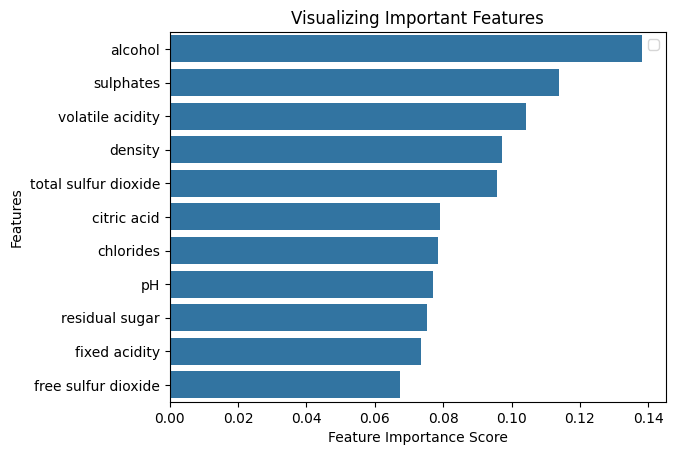

In [61]:
%matplotlib inline
import seaborn as sns

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Tuning Model

In [62]:

rf = RandomForestClassifier(random_state = 0)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [63]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 14, num = 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [64]:

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=0, n_jobs = -1)

rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\15306\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
250 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
103 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\15306\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\15306\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

Best Parameters

In [65]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Evaluate Base Model

In [66]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test,y_test)

Model Performance
Average Error: 0.3281 degrees.
Accuracy = 93.79%.


Evaluate Improved Model

In [67]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.3063 degrees.
Accuracy = 94.07%.
